In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader 

from dataset import CustomDataset 

import torch
import torch.nn as nn

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm

import matplotlib.pyplot as plt

## vgg 16 pretrained model 가지고오기
import torchvision.models as models 
from custom_models import *

from sklearn.metrics import recall_score, f1_score, accuracy_score

In [2]:
train_dir = 'data/train'
valid_dir = 'data/valid'

# train_transform = transforms.Compose([
#     transforms.ToTensor(), #=> 0~1
#     transforms.Resize((224,224), antialias=True),
#     # transforms.Resize((299,299), antialias=True),
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomRotation(degrees=30),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ColorJitter(contrast=2),
#     # transforms.GaussianBlur(kernel_size = (3,3)),
#     transforms.Grayscale(num_output_channels=3),
# ])

train_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias= True), # 혹은 모델에 맞는 다른 사이즈로 조정
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), antialias= True),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2)
    ], p=0.7),
])


valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    # transforms.Resize((299,299), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    # transforms.Normalize((0.5), (0.5)),
    
])
# batch
tr_batch = 50
vl_batch = 25

train_dataset = CustomDataset(root_dir = train_dir, transform= train_transform)
valid_dataset = CustomDataset(root_dir = valid_dir, transform= valid_transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle= True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)

valid_input_shape : torch.Size([25, 3, 224, 224])
intensity check : 0.0~0.9998998641967773
****************************************************************************************************


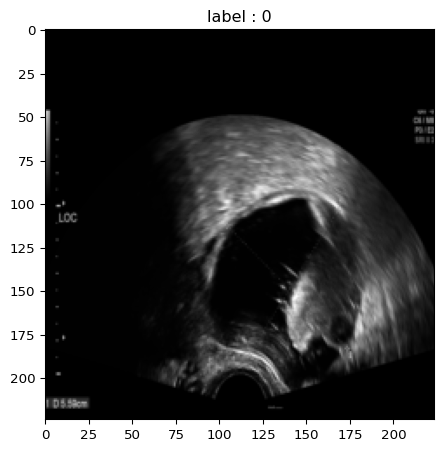

In [3]:
# for images, labels in train_loader:
#     print(f'train_input_shape : {images.shape}')
#     break 
for images, labels in valid_loader:
    print(f'valid_input_shape : {images.shape}')
    break 

print(f"intensity check : {images.min()}~{images.max()}")
print('*'*100)
plt.figure(dpi = 96)
plt.subplot(111)
plt.imshow(images[0,0,:,:], cmap= 'gray')
plt.title(f'label : {labels[0].to(int).item()}')
# plt.title(f'type 1')
# plt.subplot(132)
# plt.imshow(images[0,1,:,:], cmap= 'gray')
# plt.title(f'type 2')
# plt.subplot(133)
# plt.imshow(images[0,2,:,:], cmap= 'gray')
# plt.title(f'type 3')
plt.tight_layout()
plt.show()


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'device : {device}')

pretrained_model = pretrained_mobilenet_binary()
pretrained_model.to(device)

device : cuda


c:\Users\dablr\.conda\envs\eiden\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained_mobilenet_binary(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16,

In [5]:
# cost func & optimizer 정의
epoch, epochs = 0, 200
lr = 0.0001
loss = nn.BCEWithLogitsLoss() #-> 마지막 layer에 softmax/sigmoid 함수 넣어주기 

optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer, lr_lambda = lambda epcoh: 0.95)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer,
                                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                                        last_epoch = -1,
                                                        verbose= True)
# 모델 구조 출력 
print(f"cuda : {device}")
summary(pretrained_model, input_size=(3, 224, 224))


Adjusting learning rate of group 0 to 1.0000e-04.
cuda : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 5

In [6]:
metrics = {
    'train_loss' : [],
    'valid_loss' : [],
    'train_accuracy' : [],
    'train_f1' : [],
    'train_recall' : [],
    'valid_accuracy' : [],
    'valid_f1' : [],
    'valid_recall' : [],
}


In [7]:
# 조기 종료 변수 초기화
early_stopping_epochs, early_stop_cnt = 10, 0
best_loss = float('inf')


for epoch in tqdm(range(epoch, epochs)):
    
    train_losses = 0. 
    valid_losses = 0. 

    train_target, train_pred, valid_target, valid_pred = [],[],[],[]
    
    pretrained_model.train()
    for _, (inputs, labels) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad() 
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = pretrained_model(inputs)
        
        train_loss = loss(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        
        # 예측 값을 이진 레이블로 변환
        pred = (F.sigmoid(outputs) > 0.5).float()
        train_target.extend(labels.detach().cpu().numpy())
        train_pred.extend(pred.detach().cpu().numpy())
    
    metrics['train_loss'].append(train_losses/len(train_loader))
    metrics['train_accuracy'].append(accuracy_score(train_target, train_pred))
    metrics['train_f1'].append(f1_score(train_target, train_pred))
    metrics['train_recall'].append(recall_score(train_target, train_pred))
    
    scheduler.step()
    
    with torch.no_grad():
        pretrained_model.eval()
        for _, (inputs, labels) in tqdm(enumerate(valid_loader)):
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = pretrained_model(inputs)
            
            valid_loss = loss(outputs, labels)
            valid_losses += valid_loss.item()
            
            # 예측 값을 이진 레이블로 변환
            pred = (F.sigmoid(outputs) > 0.5).float()
            valid_target.extend(labels.detach().cpu().numpy())
            valid_pred.extend(pred.detach().cpu().numpy())
        metrics['valid_loss'].append(valid_losses/len(valid_loader))
        metrics['valid_accuracy'].append(accuracy_score(valid_target, valid_pred))
        metrics['valid_f1'].append(f1_score(valid_target, valid_pred))
        metrics['valid_recall'].append(recall_score(valid_target, valid_pred))
    
    
    
    print("#"*100)    
    print(f"LOSS : {metrics['train_loss'][-1]} | {metrics['valid_loss'][-1]}\n ACC : {metrics['train_accuracy'][-1]} | {metrics['valid_accuracy'][-1]}\n F1 : {metrics['train_f1'][-1]} | {metrics['valid_f1'][-1]}\n RECALL : {metrics['train_recall'][-1]} | {metrics['valid_recall'][-1]}")
    print("#"*100)
    
    
        
    # Early Stopping
    if valid_loss > np.array(metrics['valid_loss']).max():
        early_stop_cnt += 1
    else:
        best_loss = valid_loss
        early_stop_cnt = 0
    
    # 조기 종료 조건 확인
    if early_stop_cnt >= early_stopping_epochs:
        print(f"Early Stops!!! : {epoch}/{epochs}")
        
        torch.save({
            "model" : f"{epoch}",
            "epoch" : epoch,
            "epochs" : epochs,
            "model_state_dict" : pretrained_model.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict(),
            "learning_rate" : lr,
            "loss" : loss,
            "metric" : metrics,
            "description" : f"vggnet training status : {epoch}/{epochs}"
        },
        f'./metric/vgg16.pt')
        
        print(f"SAVE MODEL PATH : ./metric/@@@@@@.pt")
        break
    else:
        if accuracy_score(valid_target, valid_pred) > np.array(metrics['valid_recall']).max():
            torch.save({
                "model" : f"{epoch}",
                "epoch" : epoch,
                "epochs" : epochs,
                "model_state_dict" : pretrained_model.state_dict(),
                "optimizer_state_dict" : optimizer.state_dict(),
                "learning_rate" : lr,
                "loss" : loss,
                "metric" : metrics,
                "description" : f"vggnet training status : {epoch}/{epochs}"
            },
            f'./metric/vgg16.pt')
            
            print(f"SAVE MODEL PATH : ./metric/@@@@@@.pt")
    
    
    
    
    
    
        

48it [00:42,  1.14it/s][00:00<?, ?it/s]


Adjusting learning rate of group 0 to 9.5000e-05.


12it [00:04,  2.99it/s]


####################################################################################################
LOSS : 0.6136304711302122 | 0.5520668998360634
 ACC : 0.6835229667088074 | 0.6936026936026936
 F1 : 0.020860495436766626 | 0.0
 RECALL : 0.011019283746556474 | 0.0
####################################################################################################


  0%|          | 1/200 [00:47<2:38:31, 47.80s/it]

SAVE MODEL PATH : ./metric/@@@@@@.pt


48it [00:41,  1.15it/s]


Adjusting learning rate of group 0 to 9.0250e-05.


12it [00:03,  3.01it/s]


####################################################################################################
LOSS : 0.5484361536800861 | 0.4336329971750577
 ACC : 0.7324062368310156 | 0.8181818181818182
 F1 : 0.3911792905081496 | 0.6823529411764706
 RECALL : 0.2809917355371901 | 0.6373626373626373
####################################################################################################


  1%|          | 2/200 [01:35<2:36:44, 47.50s/it]

SAVE MODEL PATH : ./metric/@@@@@@.pt


48it [00:41,  1.15it/s]


Adjusting learning rate of group 0 to 8.5737e-05.


2it [00:00,  2.16it/s]
  1%|          | 2/200 [02:17<3:47:09, 68.84s/it]


KeyboardInterrupt: 

In [28]:
np.array(metrics['train_loss'])

array([0.61018086, 0.53311347])

In [29]:
np.array(metrics['train_loss']).max()

0.6101808610061804